<a href="https://colab.research.google.com/github/lukasztracz195/NeuralNetworkGANToGenZeroFromMNIST/blob/main/MNIST_ZERO_GAN_1000_wskazowki%20profesora_epocs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementacja sieci GAN do nauczenia się jak wygląda liczba 0

##Import bibliotek

###Ustawienie odpowiedniej biblioteki TensoreFlow

In [143]:
# To determine which version you're using:
!pip show tensorflow

# For a specific version:
!pip install tensorflow==2.4

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorboard, absl-py, keras-preprocessing, gast, flatbuffers, h5py, astunparse, numpy, typing-extensions, tensorflow-estimator, opt-einsum, termcolor, wheel, six, wrapt, google-pasta, grpcio, protobuf
Required-by: Keras, fancyimpute


###Instalacja odpowiedniej biblioteki Keras

In [144]:
!pip3 install keras==2.4
!pip3 show keras

Name: Keras
Version: 2.4.0
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, h5py, scipy, tensorflow, pyyaml
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


###Instalacja odpowiednich zbiorów danych

In [145]:
%%bash
pip install python-mnist
pip install tensorflow-datasets

#Zamontowanie dysku google

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import time
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

#Implementacja klasy ElapsedTimer

In [3]:
import time
class ElapsedTimer(object):
    def __init__(self):
        self.__start_time = time.time()

    @staticmethod
    def __elapsed(sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"

    def elapsed_time(self):
        print("Elapsed: %s " % self.__elapsed(time.time() - self.__start_time))

#Implementacja klasy DCGAN


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
import time

class DCGAN:
    def __init__(self, img_rows=28, img_cols=28, channel_color=1):
        self.__img_rows = img_rows
        self.__img_cols = img_cols
        self.__channel = channel_color
        self.__discriminator = None  # discriminator
        self.__generator = None  # generator
        self.__adversarial_model = None  # adversarial model // model przeciwności
        self.__discriminator_model = None  # discriminator model // model dyskrymiancji
        self.__optimizer_for_discriminator_model = None
        self.__loss_for_discriminator_model = None
        self.__metrics_for_discriminator_model = None
        self.__optimizer_for_adversarial_model = None
        self.__loss_for_adversarial_model = None
        self.__metrics_for_adversarial_model = None
        self.__path_to_save_images = None
        self.__train_X = None
        self.__train_Y = None
        self.__loss_history_for_generator = list()
        self.__accuracy_history_for_generator = list()
        self.__duration_history_for_generator = list()

        self.__loss_history_for_discriminator = list()
        self.__accuracy_history_for_discriminator = list()
        self.__duration_history_for_discriminator = list()

    @property
    def loss_history_for_generator(self):
        return self.__loss_history_for_generator

    @property
    def accuracy_history_for_generator(self):
        return self.__accuracy_history_for_generator

    @property
    def duration_history_for_generator(self):
        return self.__duration_history_for_generator

    @property
    def loss_history_for_discriminator(self):
        return self.__loss_history_for_discriminator

    @property
    def accuracy_history_for_discriminator(self):
        return self.__accuracy_history_for_discriminator

    @property
    def duration_history_for_discriminator(self):
        return self.__duration_history_for_discriminator

    @property
    def img_rows(self):
        return

    @img_rows.setter
    def img_rows(self, value):
        self.__img_rows = value

    @property
    def img_cols(self):
        return self.__img_cols

    @img_cols.setter
    def img_cols(self, value):
        self.__img_cols = value

    @property
    def channel(self):
        return self.__channel

    @channel.setter
    def channel(self, value):
        self.__channel = value

    @property
    def discriminator(self):
        return self.__discriminator

    @discriminator.setter
    def discriminator(self, value):
        self.__discriminator = value

    @property
    def generator(self):
        return self.__generator

    @generator.setter
    def generator(self, value):
        self.__generator = value

    @property
    def loss_for_discriminator_model(self):
        return self.__loss_for_discriminator_model

    @loss_for_discriminator_model.setter
    def loss_for_discriminator_model(self, value):
        self.__loss_for_discriminator_model = value

    @property
    def optimizer_for_discriminator_model(self):
        return self.__optimizer_for_discriminator_model

    @optimizer_for_discriminator_model.setter
    def optimizer_for_discriminator_model(self, value):
        self.__optimizer_for_discriminator_model = value

    @property
    def metrics_for_discriminator_model(self):
        return self.__metrics_for_discriminator_model

    @metrics_for_discriminator_model.setter
    def metrics_for_discriminator_model(self, value):
        self.__metrics_for_discriminator_model = value

    @property
    def loss_for_adversarial_model(self):
        return self.__loss_for_adversarial_model

    @loss_for_adversarial_model.setter
    def loss_for_adversarial_model(self, value):
        self.__loss_for_adversarial_model = value

    @property
    def optimizer_for_adversarial_model(self):
        return self.__optimizer_for_adversarial_model

    @optimizer_for_adversarial_model.setter
    def optimizer_for_adversarial_model(self, value):
        self.__optimizer_for_adversarial_model = value

    @property
    def metrics_for_adversarial_model(self):
        return self.__metrics_for_adversarial_model

    @metrics_for_adversarial_model.setter
    def metrics_for_adversarial_model(self, value):
        self.__metrics_for_adversarial_model = value

    @property
    def path_to_save_images(self):
        return self.__path_to_save_images

    @path_to_save_images.setter
    def path_to_save_images(self, value):
        self.__path_to_save_images = value

    @property
    def discriminator_model(self):
        if self.__discriminator_model:
            return self.__discriminator_model
        self.__discriminator_model = Sequential()
        self.__discriminator_model.add(self.discriminator)
        # print("discriminator_model {loss= ",self.__loss_for_discriminator_model,
        #       " optimizer= ",self.__optimizer_for_discriminator_model,
        #       " metrics= ",self.__metrics_for_discriminator_model)
        self.__discriminator_model.compile(loss=self.__loss_for_discriminator_model,
                                           optimizer=self.__optimizer_for_discriminator_model,
                                           metrics=self.__metrics_for_discriminator_model)
        return self.__discriminator_model

    @property
    def adversarial_model(self):
        if self.__adversarial_model:
            return self.__adversarial_model
        discriminator = self.discriminator
        discriminator.trainable = False
        self.__adversarial_model = Sequential()
        self.__adversarial_model.add(self.generator)
        self.__adversarial_model.add(discriminator)
        # print("adversarial_model {loss= ",self.__loss_for_adversarial_model,
        #       " optimizer= ",self.__optimizer_for_adversarial_model,
        #       " metrics= ",self.__metrics_for_adversarial_model)
        self.__adversarial_model.compile(loss=self.__loss_for_adversarial_model,
                                         optimizer=self.__optimizer_for_adversarial_model,
                                         metrics=self.__metrics_for_adversarial_model)

        return self.__adversarial_model

    def train(self, train_X, train_Y, train_steps=10, batch_size=256, save_interval=0, debug=False):
        self.__train_X = train_X
        self.__train_Y = train_Y
        self.__clear_statistics()
        noise_input = None
        if save_interval > 0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

        for i in range(train_steps):
            start_d = time.time()
            #wyciągnięcie danych ze zbioru treningowego
            images_train = self.__train_X[np.random.randint(0, self.__train_X.shape[0], size=batch_size), :, :, :]
            #Utworzenie szumu
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            #Pobranie od generatora wygenerowanych obrazów
            images_fake = self.generator.predict(noise)
            if debug == True:
              print('images_train.shape= ', images_train.shape)
              print('images_fake.shape= ', images_fake.shape)
            #dołączenie do obrazów prawdziwych obrazów fałszywych
            x = np.concatenate((images_train, images_fake))
            #utwrozenie zbioru etykied dla zbioru prawdziwych i fałszywych obrazów
            y = np.ones([2 * batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator_model.train_on_batch(x, y)
            end_d = time.time()
            duration_d = end_d - start_d
            start_g = time.time()
            y = np.ones([batch_size, 1])
            # wygenerować szum
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial_model.train_on_batch(noise, y)
            end_g = time.time()
            duration_g = end_g - start_g
            self.__save_statistics(discriminator_stat=d_loss, discriminator_duration=duration_d,
                                   generator_stat=a_loss, generator_duration=duration_g)
            log_message = "%d: [Discriminator loss: %f, acc: %f | duration: %f s]" % (
                i, d_loss[0], d_loss[1], duration_d)
            log_message = "%s  [Generator loss: %f, acc: %f | duration: %f s]" % (
                log_message, a_loss[0], a_loss[1], duration_g)
            print(log_message)
            if save_interval > 0 and noise_input is not None:
                if ((i + 1) % save_interval) == 0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input,
                                     step=(i + 1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.__train_X.shape[0], samples)
            images = self.__train_X[i, :, :, :]

        plt.figure(figsize=(10, 10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i + 1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.__img_rows, self.__img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(self.__path_to_save_images + '/' + filename)
            plt.close('all')
        else:
            plt.show()

    def __clear_statistics(self):
        self.__loss_history_for_generator = list()
        self.__accuracy_history_for_generator = list()
        self.__duration_history_for_generator = list()

        self.__loss_history_for_discriminator = list()
        self.__accuracy_history_for_discriminator = list()
        self.__duration_history_for_discriminator = list()

    def __save_statistics(self, discriminator_stat, generator_stat, discriminator_duration, generator_duration):
        self.__loss_history_for_generator.append(generator_stat[0])
        self.__accuracy_history_for_generator.append(generator_stat[1])
        self.__duration_history_for_generator.append(generator_duration)

        self.__loss_history_for_discriminator.append(discriminator_stat[0])
        self.__accuracy_history_for_discriminator.append(discriminator_stat[1])
        self.__duration_history_for_discriminator.append(discriminator_duration)


#Zdefiniowanie funckji dla wykresów

In [5]:
def make_accuracy_plot(history):
  """
  Funckja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym.
  """

  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()
  # acc = history.history['accuracy'], history.history['val_accuracy']
  acc = history
  epochs = range(1, len(acc)+1)

  plt.figure(figsize=(20,10))
  plt.plot(epochs, acc, label='Dokladność trenowania', marker='o')
  # plt.plot(epochs, val_acc, label='Dokladność walidacji', marker='o')
  plt.legend()
  plt.title('Dokładność trenowania')
  plt.xlabel('Epoki')
  plt.ylabel('Dokładność')
  plt.show()



def make_loss_plot(history):
  """
  Funkjca zwraca wykres straty (loss) modelu na zbiorze treningowym
  """

  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()
  # loss, val_loss = history.history['loss'], history.history['val_loss']
  loss = history
  epochs = range(1, len(loss)+ 1)

  plt.figure(figsize = (20,10))
  plt.plot(epochs, loss, label='Strata trenowania', marker='o')

  # plt.plot(epochs, val_loss, label="Strata walidacji", marker='o')
  plt.legend()
  plt.title('Strata trenowania')
  plt.xlabel('Epoki')
  plt.ylabel('Strata')
  plt.show()

def make_durration_plot(history):
  """
  Funkjca zwraca wykres czasu wykonania modelu na zbiorze treningowym
  """

  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()
  # loss, val_loss = history.history['loss'], history.history['val_loss']
  duration = history
  epochs = range(1, len(duration)+ 1)

  plt.figure(figsize = (20,10))
  plt.plot(epochs, duration, label='Czas wykonania', marker='o')
  # plt.plot(epochs, val_loss, label="Strata walidacji", marker='o')
  plt.legend()
  plt.title('Czas wykonanaia')
  plt.xlabel('Epoki')
  plt.ylabel('Czas wykonania w s')
  plt.show()



##Utworzenie instancji klasy DCGAN

In [6]:
dcgan = DCGAN()

#Utworzenie sieci dla modułu generatora

In [7]:
from tensorflow.keras.models import Sequential
# from keras.models import Sequential
generator = Sequential()
dropout = 0.4
depth = 64 + 64 + 64 + 64
dim = 28
dim_output = 28
# In: 100
# Out: dim x dim x depth
# zbudować wektor który będe mógł najszybciej zamienić na dwuwymiarową strukturę
# generator ma za zadzanie powiększanie rozdzielczości
# - sposób 1 użycie upsamplingu
# - sposób 2 
#blok 7 * 7 * coś co pozwoli mi dalej przekształcać macierze dwuwymiarowe
#w dalszych warstwach/plastrów
generator.add(Dense(units=dim * dim * depth, input_dim=100)) # blok 7 * 7 * coś co pozwoli mi w 
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))

# In: dim x dim x depth
# Out: 2*dim x 2*dim x depth/2
generator.add(Conv2DTranspose(int(depth / 2), 2, padding='same'))
generator.add(Activation('relu'))
# Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
generator.add(Conv2D(1, 5, padding='same'))
generator.add(Activation('sigmoid'))
generator.summary()

dcgan.generator = generator

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200704)            20271104  
_________________________________________________________________
activation (Activation)      (None, 200704)            0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 128)       131200    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 1)         3201      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 1)         0

#Określenie rozmiaru warstwy wejściowej

In [8]:
input_shape = (28, 28, 1)
dcgan.img_rows = 28
dcgan.img_cols = 28
dcgan.channel = 1

#Utworzenie sieci dla modułu dyskryminatora

In [9]:
from keras.models import Sequential
discriminator = Sequential()
# In: 28 x 28 x 1, depth = 1
# Out: 14 x 14 x 1, depth=64
discriminator.add(Conv2D(filters=32, kernel_size=5, strides=2, input_shape=input_shape, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
#kernel size powinien maleć
#tańszym roziwązaniem jest zastosować kernel_size=3
# a potem wykorzystać maxpulling
# zmniejszenie rozdzielczości 
# zmniejszyć liczbę parametrów

discriminator.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))

# Out: 1-dim probability
discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.summary()


dcgan.discriminator = discriminator
# pierwsza warstwa ma rozmiar zdeterminiowany obrazem
# druga warstwa powinna być 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         102528    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

###Określenie optimizera, funkcji celu oraz metryk dla modelu dyskryminacji i modelu przeciwności

In [10]:
from keras.optimizers import Adam, RMSprop
dcgan.optimizer_for_discriminator_model = RMSprop(lr=0.0002, decay=6e-8)
dcgan.optimizer_for_adversarial_model = RMSprop(lr=0.0001, decay=3e-8)
dcgan.loss_for_discriminator_model = 'binary_crossentropy'
dcgan.loss_for_adversarial_model = 'binary_crossentropy'
dcgan.metrics_for_discriminator_model = ['accuracy']
dcgan.metrics_for_adversarial_model = ['accuracy']

#Przygotowanie danych treningowych ze zbioru MNIST

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
# print(os.listdir("./sample_data"))
mnistO = pd.read_csv("./sample_data/mnist_train_small.csv")
#Ekstrakcja obrazów przedstawiających tylko zero
mnist = mnistO[mnistO.iloc[:,0]==0]
mnist = mnist.iloc[:,1:]
mnist = np.array(mnist)/255
print(mnist.shape)

mnist_images_zero = mnist.reshape(mnist.shape[0], 28,28,1)
# mnist_images_zero = mnist
print(mnist_images_zero.shape)

(1962, 784)
(1962, 28, 28, 1)


#Ustawienie folderu do zapisu obrazów z generatora

In [12]:
%%bash
pwd
cd ./gdrive
pwd
ls
cd ./MyDrive
cd ./'Colab Notebooks'
pwd
cd ./gan_zero_colab
pwd


/content
/content/gdrive
MyDrive
Shareddrives
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/gan_zero_colab


In [13]:
dcgan.path_to_save_images = '/content/gdrive/MyDrive/Colab Notebooks/gan_zero_colab_v2'

#Uruchomienie działania GANA

In [159]:
timer = ElapsedTimer()
dcgan.train(train_X=mnist_images_zero, train_Y=None, train_steps=1000, batch_size=256, save_interval=1, debug=False)
timer.elapsed_time()

0: [Discriminator loss: 0.705138, acc: 0.378906 | duration: 2.645878 s]  [Generator loss: 0.748668, acc: 0.000000 | duration: 6.770082 s]
1: [Discriminator loss: 0.653296, acc: 0.994141 | duration: 2.103549 s]  [Generator loss: 0.802787, acc: 0.000000 | duration: 6.051776 s]
2: [Discriminator loss: 0.618311, acc: 1.000000 | duration: 2.071504 s]  [Generator loss: 0.853517, acc: 0.000000 | duration: 6.044002 s]
3: [Discriminator loss: 0.584310, acc: 1.000000 | duration: 2.097370 s]  [Generator loss: 0.902969, acc: 0.000000 | duration: 6.109950 s]
4: [Discriminator loss: 0.552107, acc: 1.000000 | duration: 2.094590 s]  [Generator loss: 0.968956, acc: 0.000000 | duration: 6.103682 s]
5: [Discriminator loss: 0.522246, acc: 1.000000 | duration: 2.113359 s]  [Generator loss: 1.026046, acc: 0.000000 | duration: 6.028847 s]
6: [Discriminator loss: 0.489115, acc: 1.000000 | duration: 2.110127 s]  [Generator loss: 1.087367, acc: 0.000000 | duration: 6.027723 s]
7: [Discriminator loss: 0.457513, 

#Wyświetlenie wygenerowanych obrazów

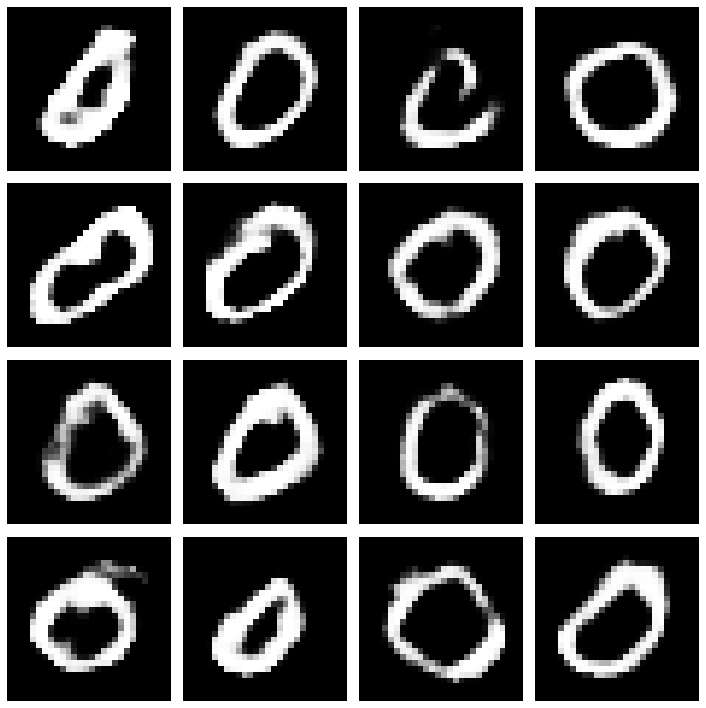

In [160]:
dcgan.plot_images(fake=True)

Slider

In [14]:
import glob
list_generated_images = list()
for file_name in glob.iglob(dcgan.path_to_save_images + '/*.png', recursive=True):
  list_generated_images.append(file_name)


In [15]:
def display_images(directory, index):
  from keras.preprocessing import image
  # print('directory=',directory)
  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  fnames = list(filter(lambda k: '.png' in k, fnames))
  img_path = fnames[index]
  print('img_path= ', img_path)
  img = image.load_img(img_path)
  plt.figure(figsize=(10, 100))
  plt.grid(b=None)
  plt.imshow(img)

img_path=  /content/gdrive/MyDrive/Colab Notebooks/gan_zero_colab_v2/mnist_142.png


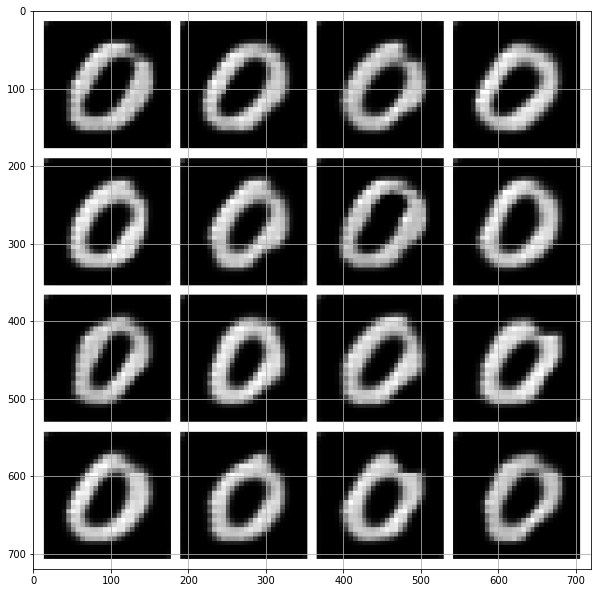

In [20]:
index = 141 #@param { type:'slider', min:0, max:999, step:1}
display_images(dcgan.path_to_save_images, index)

#Wyświetlenie prawdziwych obrazów poddawanychdyskryminatorowi

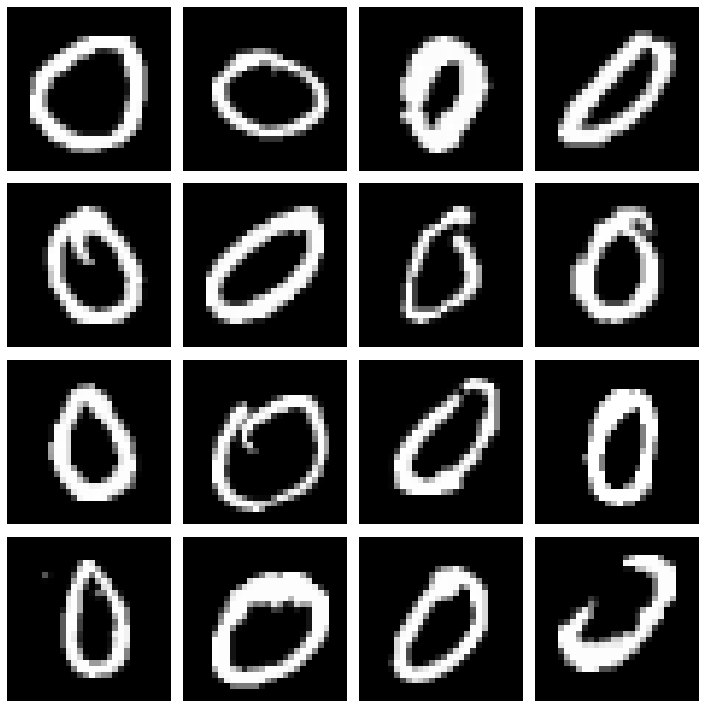

In [164]:
dcgan.plot_images(fake=False)

#

#Wykres dokładności (accuracy) modelu na zbiorze treningowym dla generatora

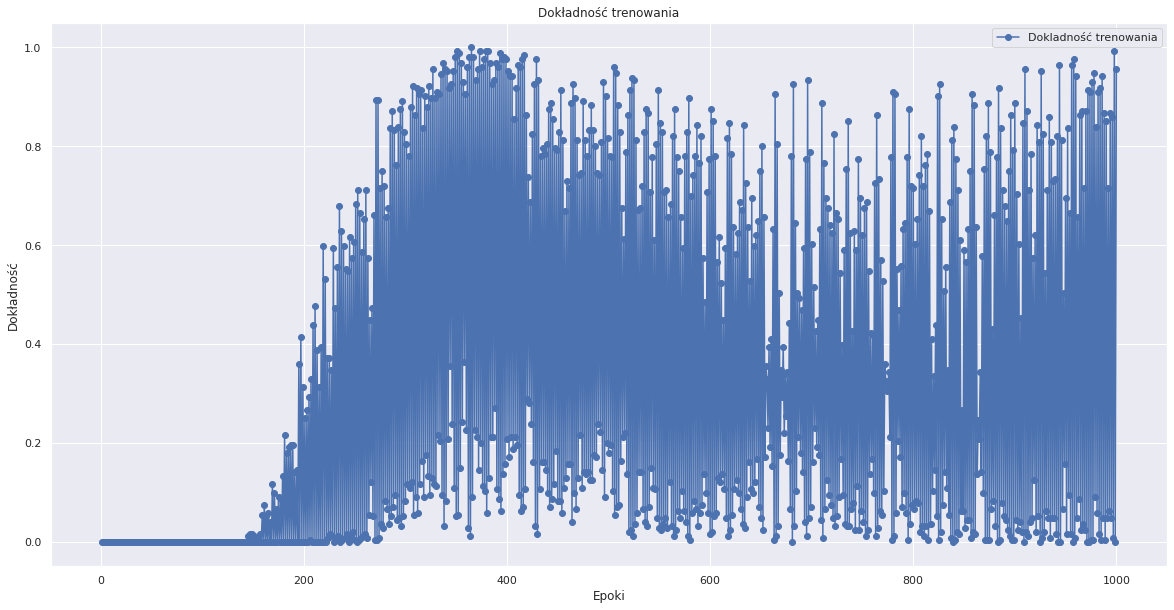

In [187]:
make_accuracy_plot(dcgan.accuracy_history_for_generator)

#wykres straty (loss) modelu na zbiorze treningowym dla generatora

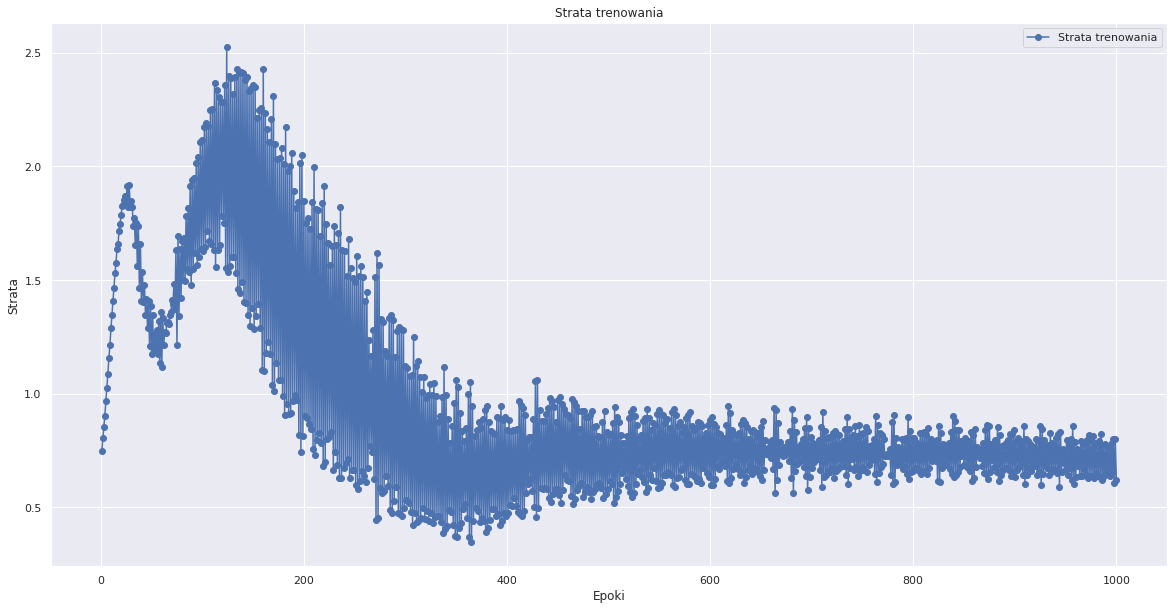

In [188]:
make_loss_plot(dcgan.loss_history_for_generator)

#Wykres czasu uczenia się dla generatora

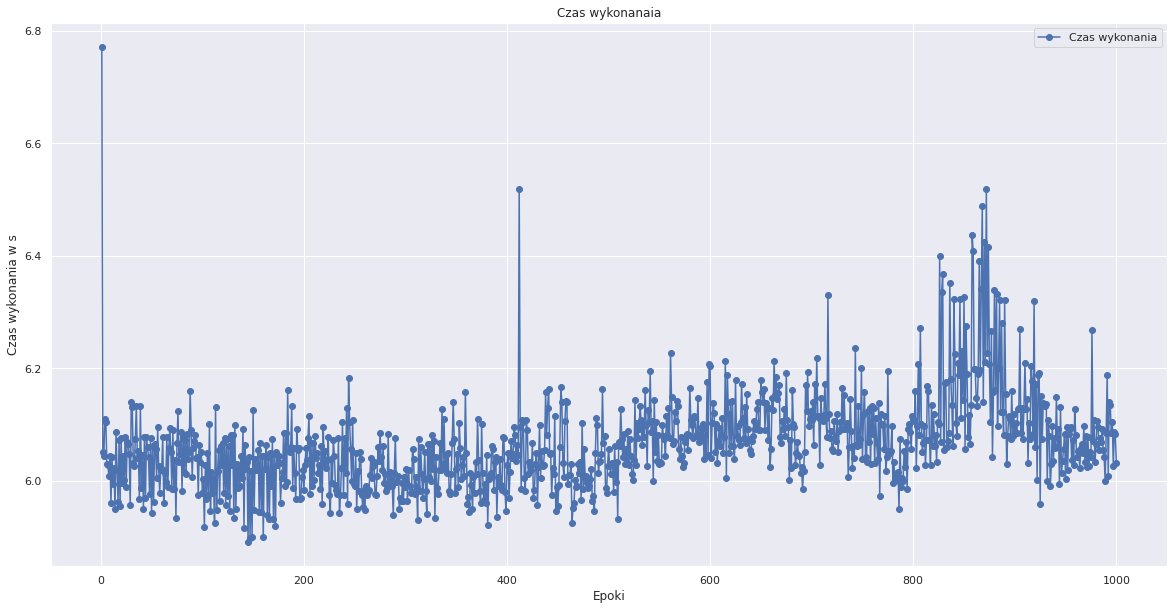

In [189]:
make_durration_plot(dcgan.duration_history_for_generator)

#Wykres dokładności (accuracy) modelu na zbiorze treningowym dla dyskryminatora

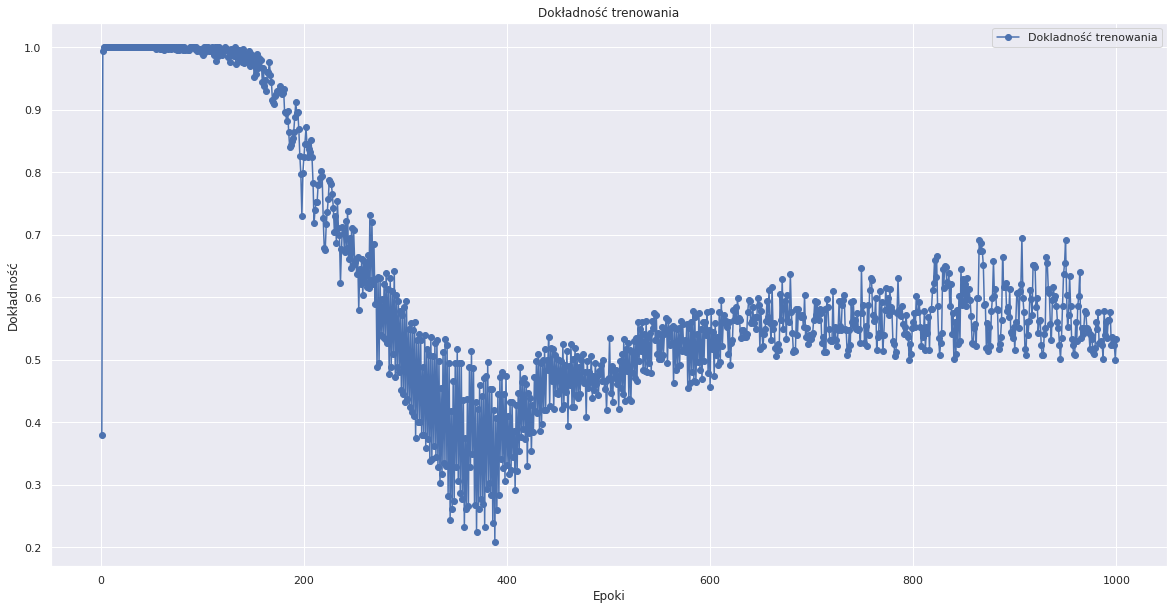

In [190]:
make_accuracy_plot(dcgan.accuracy_history_for_discriminator)

#wykres straty (loss) modelu na zbiorze treningowym dla dyskryminatora


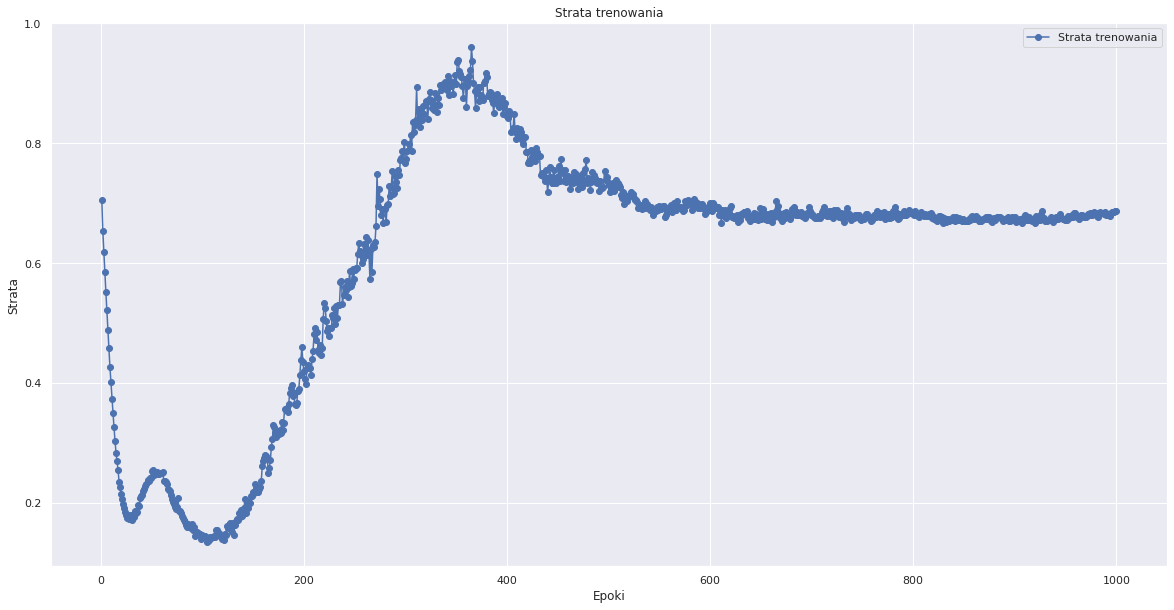

In [191]:
make_loss_plot(dcgan.loss_history_for_discriminator)

#Wykres czasu uczenia się dla dyskryminatora

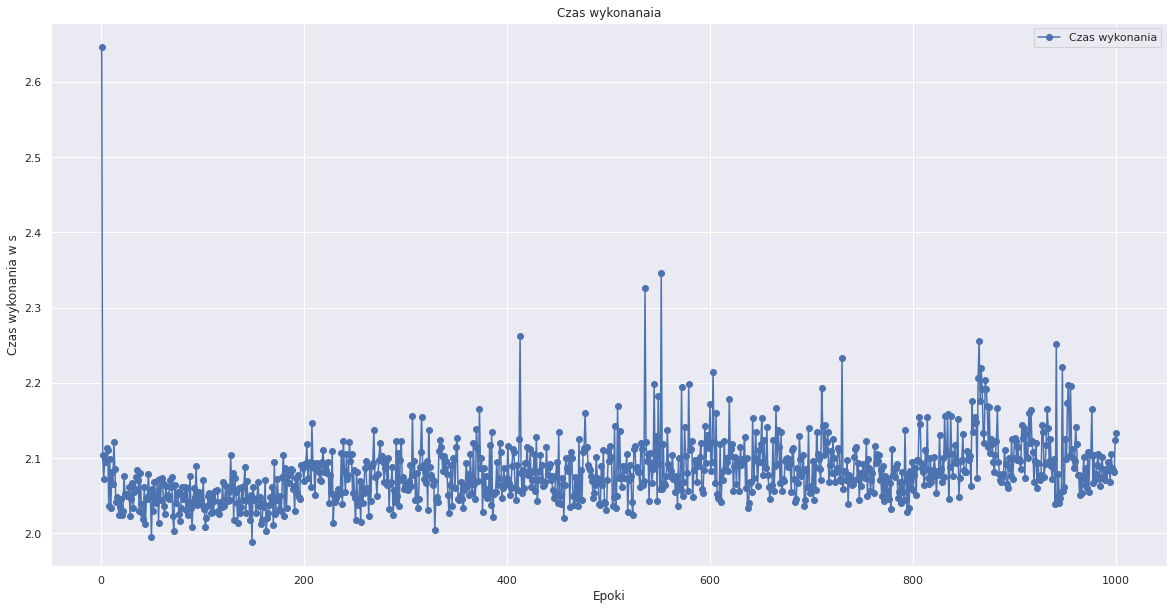

In [192]:
make_durration_plot(dcgan.duration_history_for_discriminator)